## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
data.shape

(1309, 14)

In [5]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [6]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [7]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [8]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [9]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [10]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [11]:
target = 'survived'

In [12]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

vars_num = [var for var in data.columns if var not in vars_cat and var != 'survived']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [13]:
# first in numerical variables

vars_nums_with_na = [var for var in data.columns if data[var].isnull().sum()> 0 and  var not in vars_cat]

data[vars_nums_with_na].isnull().sum().sort_values(ascending=False)

age     263
fare      1
dtype: int64

In [14]:
# now in categorical variables

vars_cats_with_na = [var for var in data.columns if data[var].isnull().sum()> 0 and  var not in vars_num]

data[vars_cats_with_na].isnull().sum().sort_values(ascending=False)

cabin       1014
embarked       2
dtype: int64

### Determine cardinality of categorical variables

<AxesSubplot: >

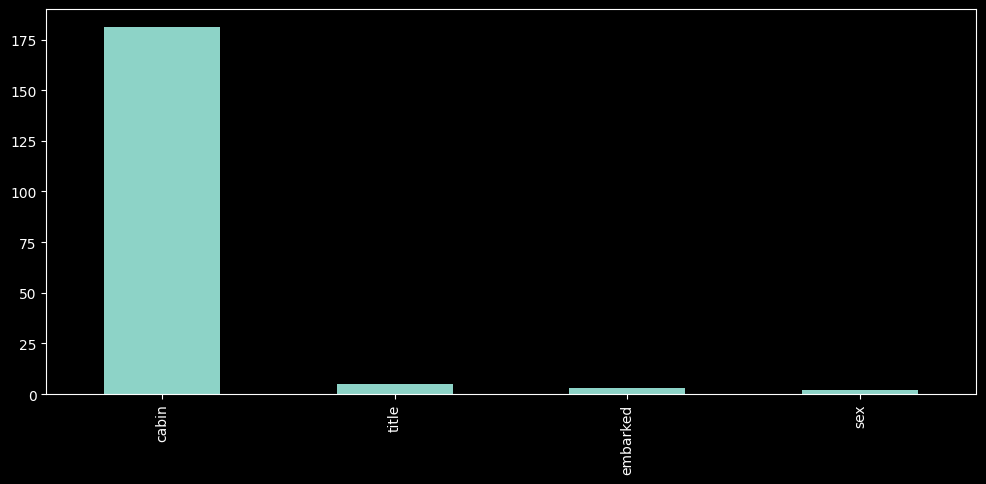

In [15]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Determine the distribution of numerical variables

<AxesSubplot: >

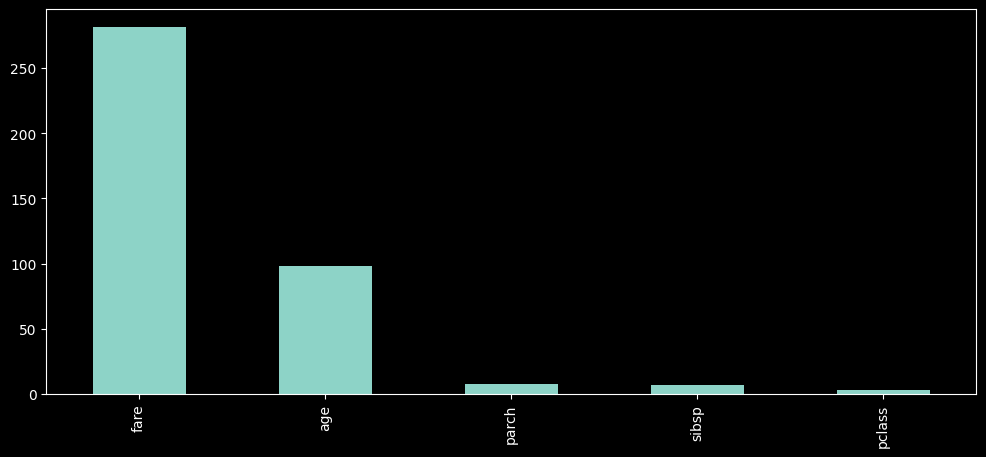

In [16]:
data[vars_num].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [18]:
#dropping the number from cabin column of X_train
X_train['cabin'] = np.where(X_train['cabin'].notnull(),X_train['cabin'].astype(np.str).str[0],np.nan)
X_train['cabin'].value_counts()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21136\914023399.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train['cabin'] = np.where(X_train['cabin'].notnull(),X_train['cabin'].astype(np.str).str[0],np.nan)


C    78
B    52
E    36
D    36
A    19
F    18
G     4
T     1
Name: cabin, dtype: int64

In [19]:
#dropping the number from cabin column of X_test
X_test['cabin'] = np.where(X_test['cabin'].notnull(),X_test['cabin'].astype(np.str).str[0],np.nan)
X_test['cabin'].value_counts()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21136\3674555831.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test['cabin'] = np.where(X_test['cabin'].notnull(),X_test['cabin'].astype(np.str).str[0],np.nan)


C    16
B    13
D    10
E     5
A     3
F     3
G     1
Name: cabin, dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [20]:
vars_with_na = [var for var in vars_num if X_train[var].isnull().sum() > 0]

X_train[vars_with_na].isnull().mean()


for var in vars_with_na:

    # First, we calculate the mean using the train set
    median_val = X_train[var].median()
    print(var, median_val)
    # adding binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    # replace missing values by the mean in train and test
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)

# checking that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age 28.0
fare 14.4542


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [21]:
X_train[vars_cats_with_na] = X_train[vars_cats_with_na].fillna('Missing')
X_test[vars_cats_with_na] = X_test[vars_cats_with_na].fillna('Missing')

In [22]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,Missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,Missing,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,Missing,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,Missing,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,Missing,S,Miss,0,0


In [23]:
# check that we have no missing information in the engineered variables

X_train[vars_cats_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [24]:
def find_frequent_labels(df, var, rare_perc, target):
    df_copy = df.copy()
    rare_qty = int(df_copy.shape[0] * rare_perc)
    value_counts = df_copy.groupby(var)[target].count()
    frequent_values = value_counts[value_counts > rare_qty].index.tolist()
    frequent_rows = df_copy[var].isin(frequent_values)
    frequent_var = df_copy.loc[frequent_rows, var]
    return frequent_var

In [25]:
for var in vars_cat:
    # Calculating the frequency of each value in the training set
    freq_table = X_train[var].value_counts(normalize=True)
    # Now, we are finding the categories that occur less frequently than the threshold
    rare_cats = freq_table[freq_table < 0.05].index
    # Replacing rare categories with "Rare" in the training set
    X_train.loc[X_train[var].isin(rare_cats), var] = "Rare"
    # Replacing rare categories with "Rare" in the test set
    X_test.loc[X_test[var].isin(rare_cats), var] = "Rare"

In [26]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,Rare,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,Missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,Missing,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,Missing,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,Missing,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,Missing,S,Miss,0,0


In [27]:
X_test

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,Missing,S,Mr,0,0
1150,3,male,28.0,0,0,14.5000,Missing,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,Missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
753,3,male,22.0,0,0,8.0500,Missing,S,Mr,0,0
1052,3,male,28.0,0,0,7.8958,Missing,S,Mr,1,0
426,2,male,30.0,0,0,13.0000,Missing,S,Mr,0,0
554,2,male,26.0,0,0,13.0000,Missing,S,Mr,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

ct = ColumnTransformer(transformers=[('OHEncode',OneHotEncoder(drop='first'),vars_cat)],remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.transform(X_test))

### Scale the variables

- Use the standard scaler from Scikit-learn

In [29]:
# For the numerical variables, we are applying Scaling technique to put the data in Normalized distribution.

scaler = StandardScaler()

# fitting the scaler to the numerical data
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [30]:
log_reg = LogisticRegression(penalty='l1', tol=0.0005, random_state=0, solver='liblinear', l1_ratio=1)
log_reg.fit(X_train, y_train)

C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(l1_ratio=1, penalty='l1', random_state=0, solver='liblinear',
                   tol=0.0005)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [32]:
y_pred = log_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.790
ROC-AUC : 0.763


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**